In [ ]:
import os
import pandas as pd
import numpy as np
import mne

import matplotlib
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm

import json


print("pandas version:", pd.__version__)
print("numpy version:", np.__version__)
print("mne version:", mne.__version__)
print("matplotlib version:", matplotlib.__version__)
print("json version:", json.__version__)

from functions import run_preprocess, run_control_decoding, run_main_decoding


datapath = '/illusory-occlusion/eeg/data'

pandas version: 2.2.3
numpy version: 1.26.4
mne version: 1.8.0
matplotlib version: 3.9.4
json version: 2.0.9


# 1. Pre-processing

In [ ]:
for participant in range(0,50):
    try:run_preprocess("%02i"%participant,0) # participant number, 0 = no overwrite
    except Exception as e:print(e)

# 2. Decoding

### Control conditions
Decodes non-targets:<br>
- Validity or the illusion (valid/invalid) across all other conditions<br>
- Position of object (in front/behind) (not relevant)<br>
- Shape of illusion (triangle/square) (not relevant)<br>

Linear Discriminant Analysis<br>

No smoothing (this is done in the stats section)


In [ ]:
for participant in range(0,50):
    try:
        run_control_decoding("%02i" % participant, 'validity', 0) #participant number, control condition to decode, 0 = no overwrite
    except Exception as e:
        print(e)

In [ ]:
for participant in range(0,50):
    try:
        run_control_decoding("%02i"% participant, 'position', 0) 
    except Exception as e:
        print(e)

In [ ]:
for participant in range(0,50):
    try:
        run_control_decoding("%02i" % participant, 'shape', 0) 
    except Exception as e:
        print(e)

### Main decoding 

Decodes non-targets:
- Category level: images (chance level = 1/90), objects (chance level = 1/30), categories (chance level = 0.1) and biological/non-biological (chance level = 0.5).<br>
- Position (in front/behind) x Validity (valid/invalid) conditions<br>

Linear Discriminant Analysis<br>

output = f'{datapath}/derivatives/results_main/sub-{subjectnr}_results_{posval_codes[c]}.csv'


In [ ]:
for participant in range(0,50):
    try:
        run_main_decoding("%02i" % participant, 0) #subject number, 0 = no overwrite
    except Exception as e:
        print(e)

# 3. Stats

### Demographics

In [ ]:
infn_demographics = f'{datapath}/participant_info.csv' # n = 29
demographics = pd.read_csv(infn_demographics, sep='\t')

ages = []
gender = []
demographics.columns = demographics.columns.str.strip()
for index, dem in demographics.iterrows():
    if 'Age' in dem:
        try:
            ages.append(float(dem['Age']))
        except ValueError:
            pass

    if 'Gender' in dem:
        gender.append(dem['Gender'])


print("Ages", "min:", np.min(ages), "max:", np.max(ages), "means ages:", np.mean(ages),
      "median ages:", np.median(ages), "std:", np.std(ages))
print("Genders:", pd.Series(gender).unique(), pd.Series(gender).value_counts())

Ages min: 17.0 max: 44.0 means ages: 27.9 median ages: 27.0 std: 7.917701686727027
Genders: ['M      ' 'F      ' 'M   ' 'NB     '] F          23
M           5
M           1
NB          1
Name: count, dtype: int64


## 3.1.1. Averaging control conditions

Loops through each participant's decoding scores, applies 10 smoothing (input is the decoding scores instead of epochs), and then calculates mean and SE. <br>

Decoding scores of the Aligment of the inducers (called validity here) to control for the presence/absence of illusory shapes.<br>

files inside derivatives/result_control/

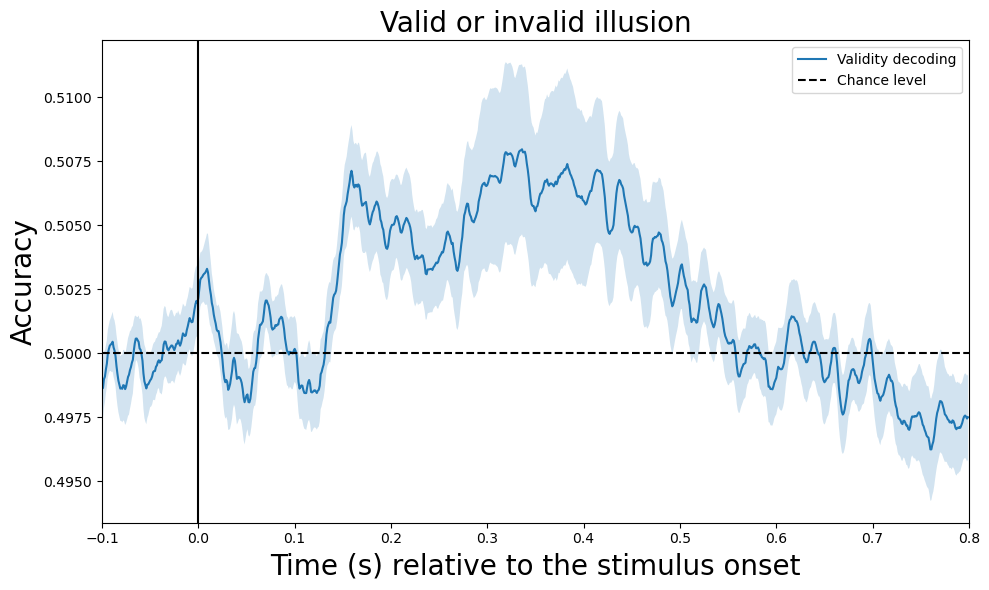

In [ ]:
subjects_val=[]

for j in range(50):
    subjectnr='%02d'%j
    infn_validity = f'{datapath}/derivatives/results_control/sub-{subjectnr}_control_validity.csv' #no smoothing yet

    
    if os.path.exists(infn_validity) and os.path.exists(infn_validity):
        V = pd.read_csv(infn_validity)
        #D = pd.read_csv(infn)
        time = V['time']


        val = pd.Series(V['validity_decoding']).rolling(window=10, min_periods=1, center=True).mean() #Smoothing the data by 10
        val = val.values
        #val = V['validity_decoding'].values
        subjects_val.append(val)
        
max_len_val = max([len(val) for val in subjects_val])
padded_val = [np.pad(val, (0, max_len_val - len(val)), constant_values=np.nan) for val in subjects_val]

# calculating the mean, ignoring NaNs
means_val = np.nanmean(np.array(padded_val).T, axis=1)
#means_val = np.mean(np.array(subjects_val).T,axis=1)

#se
se_val = np.nanstd(np.array(padded_val).T, axis=1) / np.sqrt(len(subjects_val))

# quick plot
fig,ax = plt.subplots(1, 1, figsize=(10, 6))
ax.plot(time, means_val, label='Validity decoding')
ax.fill_between(time, means_val - se_val, means_val + se_val, alpha=0.2)
ax.axhline(0.5, color='k', linestyle='--', label='Chance level')
ax.set_xlabel('Time (s) relative to the stimulus onset' , size=20)
ax.set_ylabel('Accuracy', size=20)
ax.legend()
ax.axvline(0.0, color='k', linestyle='-')
ax.set_xticks(np.arange(-0.1, 0.9, step=0.1))
ax.set_xlim(-0.1, 0.8)
ax.set_title('Valid or invalid illusion', size=20)

plt.tight_layout()
plt.show()

In [ ]:
#saving the means and se for future decoding plot 
outfn = f'{datapath}/derivatives/results_control/stats/means_control.csv' 
Y = pd.DataFrame()
Y['time'] = time
Y['means_validity'] = means_val
Y['se_validity'] = se_val

Y.to_csv(outfn)

In [ ]:
#values per subject for BFs in R
outfn = f'{datapath}/derivatives/results_control/subjects_control.csv'
X = pd.DataFrame()

for i, val in enumerate(subjects_val):
    X[f'{i}'] = val

X.to_csv(outfn, index=False)

## 3.1.2. Bayes Factors control

####  BFs in R (ttestBF)
- Input: decoding values for validity per subject "derivatives/results_control/stats/subjects_control.csv", then calculate value - chance_level (0.5)
- Output: "derivatives/results_control/stats/bf_validity_diff.csv"
- Parameters:
    - x = the differences of validity against chance per timepoint
    - y = </br>
        in case we are testing another group, but we are doing one-sample t-test, so we don't need this one
    - mu = 0 </br>
        null value of the mean (we're testing whether our x is greater than 0, because it's one-sample)
    - nullInterval = c(0.5,Inf) </br>
        prior range, to control for small effects </br>
        half-Cauchy
    - Prior: rscale = "medium" </br>
        default width (r = 0.707)</br>


Reveal the next cell for the R code

In [ ]:
'''Language: R'''

chance_level <- 0.5 
sub_val <- file.path(datapath, "derivatives/results_control/stats/subjects_control.csv") #smoothed -> done in python
if (file.exists(sub_val)) {
  all_data_validity <- read.csv(sub_val)
  print(head(all_data_validity))  # Debug
} else {
  stop("File not found: ", sub_val)
}

all_data_validity_diff <- all_data_validity - chance_level

n_timepoints <- nrow(all_data_validity_diff)

b_factors <- numeric(n_timepoints)
# Loop over each time point (rows)
for (t in 1:n_timepoints) {
  time_point_data <- as.numeric(all_data_validity_diff[t, ])  # Extract all participants for time point `t`
  time_point_data <- time_point_data[!is.na(time_point_data)]
  
  if (length(time_point_data) > 1) {
    results <- ttestBF(x = time_point_data, mu = 0, nullInterval = c(0.5,Inf), rscale = "medium")
    
    print(results)

    b_factors[t] <- results
  } 
}


b_factors_df <- data.frame(Bayes_Factor = b_factors)
output_bf_2 <- file.path(datapath, 'derivatives/results_control/stats/bf_validity_diff.csv')
write.csv(b_factors_df, output_bf_2, row.names = FALSE)


#### Plot decoding accuracies and BFs of control condition

In [ ]:
fn_bf = f'{datapath}/derivatives/results_control/stats/bf_validity_diff.csv'
bf_validity = pd.read_csv(fn_bf)
time_bf = time      #this comes from previous cells
times_numeric = np.linspace(-100, 800, len(time_bf))


for target_label, bf_values in bf_validity.items():
        print(f"Sequences of high Bayes Factors for {target_label.replace('_', ' ')}:")
        start_index = None

        # Iterate through the indices of the Bayes Factors
        for i in range(len(bf_values) - 2):  # Ensure we don't go out of range
        
            if bf_values[i] > 2:
                if start_index is None:
                    start_index = i  # Start of a new sequence
            else:
                if start_index is not None:
                    # End of the sequence
                    if i - start_index >= 9:  # We include at least 10 points, so the difference should be >= 2
                        print(f"High BF sequence from {int(times_numeric[start_index])} ms to {int(times_numeric[i])} ms.")
                    start_index = None  # Reset start index

        # Check if there's an ongoing sequence at the end of the list
        if start_index is not None and len(bf_values) - start_index >=3:
            print(f"High BF sequence from {int(times_numeric[start_index])} ms to {int(times_numeric[len(bf_values) - 1])} ms.")

Sequences of high Bayes Factors for Bayes Factor:
High BF sequence from 148 ms to 191 ms.
High BF sequence from 199 ms to 222 ms.
High BF sequence from 410 ms to 421 ms.


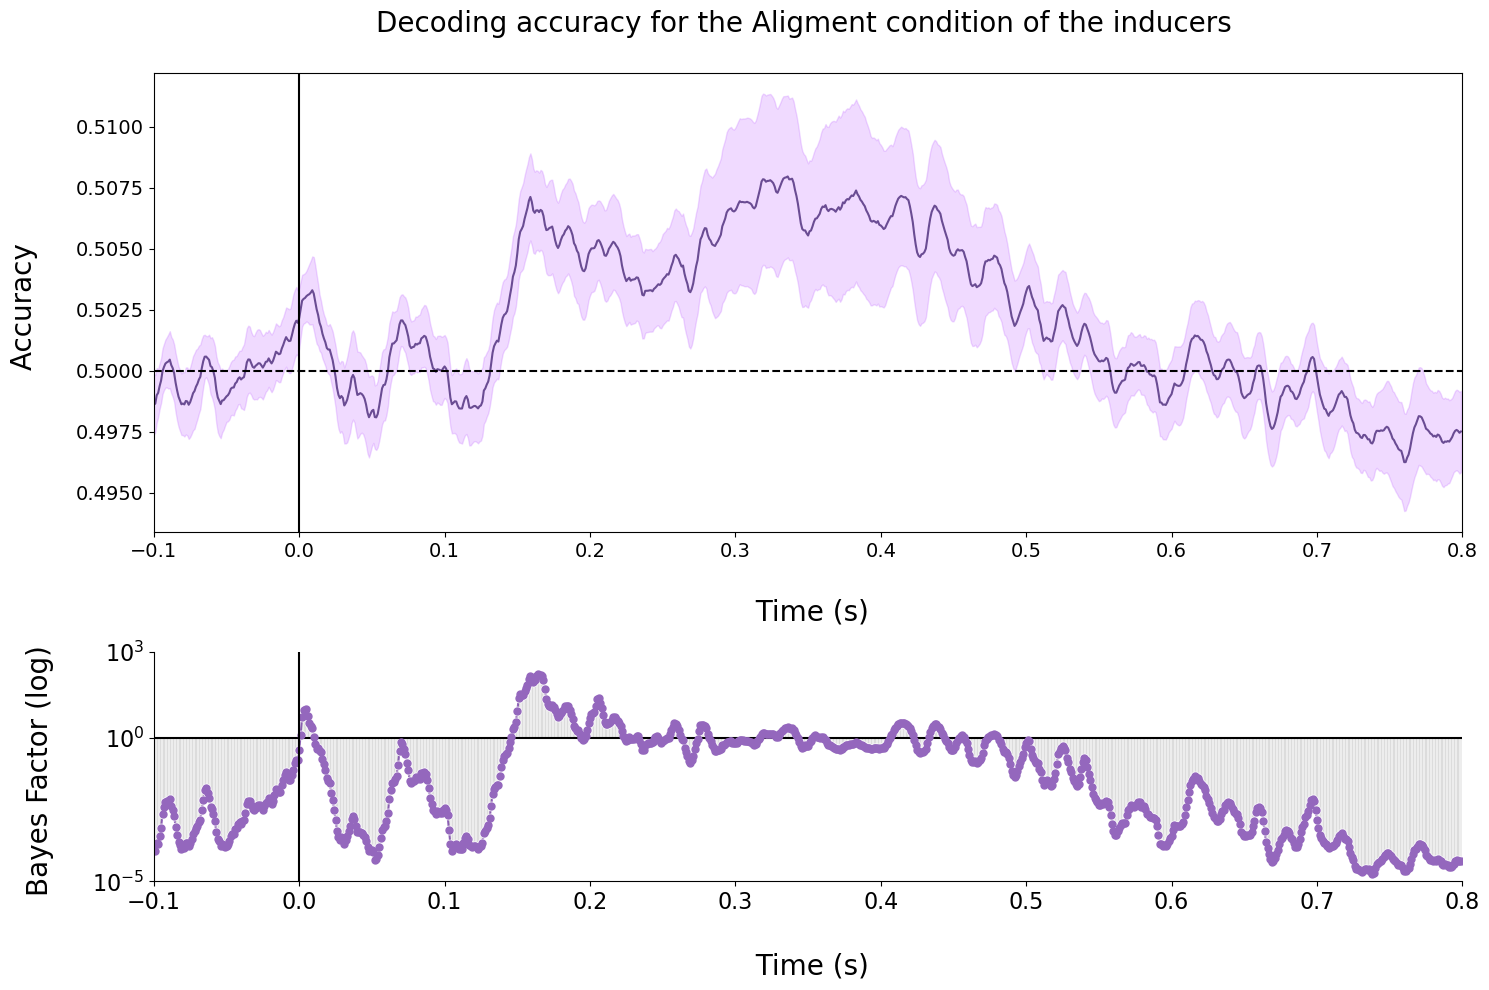

In [ ]:
BFs = pd.read_csv(f'{datapath}/derivatives/results_control/stats/bf_validity_diff.csv')
decoding = pd.read_csv(f'{datapath}/derivatives/results_control/stats/means_control.csv')


fig, axs = plt.subplots(2, 1, figsize=(15, 10), gridspec_kw={'height_ratios': [2, 1]})
#decoding scores
axs[0].plot(decoding['time'], decoding['means_validity'], label='Decoding accuracy', color='#6a4c93')
axs[0].fill_between(decoding['time'], decoding['means_validity'] - decoding['se_validity'], decoding['means_validity'] + decoding['se_validity'], alpha=0.2, color='#b449ffff')
axs[0].set_xlim(-0.1, 0.8)
axs[0].axhline(0.5, color='k', linestyle='--')
axs[0].axvline(0.0, color='k', linestyle='-')
axs[0].set_xticks(np.arange(-0.1, 0.9, step=0.1))
axs[0].tick_params(labelsize=14)

axs[0].set_xlabel('\n Time (s)', fontsize=20)
axs[0].set_ylabel('Accuracy \n', fontsize=20)
axs[0].set_title('Decoding accuracy for the Aligment condition of the inducers \n', fontsize=20)

#BFs
y = BFs['Bayes_Factor'].values
time = time_bf      #this comes from previous cell
axs[1].plot(time, y, label='Bayes Factor', color='C4')
exponential_minmax = 5
val_col_map = np.logspace(-exponential_minmax, exponential_minmax, num=500)

markerline, stemlines, baseline = axs[1].stem(time, y, bottom=1, linefmt='k', markerfmt=None, basefmt=None)
markerline.set_markerfacecolor('w')
markerline.set_markeredgecolor('w')
baseline.set_color('k')
stemlines.set_linewidth(0.1)

cols_idx = [np.argmin(np.abs(val_col_map - abs(val))) for val in y]  
for i in range(len(cols_idx)):
    axs[1].plot(time[i], y[i], color='C4', marker='.', markersize=10, lw=0, markeredgecolor=None)
axs[1].set_yscale('log')
axs[1].set_ylim([10**-exponential_minmax, 10**3])
axs[1].set_yticks([1.e-5, 1, 1.e+3])   #change this to zoom in/out on the y-axis
axs[1].set_xlim(-0.1, 0.8)
axs[1].axvline(0.0, color='k', linestyle='-')
axs[1].get_xaxis().get_major_formatter().labelOnlyBase = True
axs[1].set_xticks(np.arange(-0.1, 0.9, step=0.1))
axs[1].tick_params(labelsize=16)
axs[1].spines['right'].set_visible(False)
axs[1].spines['top'].set_visible(False)
axs[1].set_xlabel('\n Time (s)', fontsize=20)
axs[1].set_ylabel('Bayes Factor (log) \n', fontsize=20)

plt.tight_layout()
plt.show()

## 3.2.1. Averaging and smoothing main

Loops through each participant's decoding scores, applies 10 smoothing (input is the decoding scores instead of epochs), and then calculates mean and SE. <br>

This is done for image, object, category and supraordinate category decoding.<br>

Includes decoding scores of when the inducers were aligned (valid) vs misaligned (invalid), and front vs behind.<br>

input files inside derivatives/results_main

output:
- averages and se (+ smoothing) in /derivatives/results_main/stats/ -> for decoding plot directly
- only smoothing for analysis of BFs /derivatives/results_main/smoothed

In [ ]:
posval_codes = {'_front_valid_': 'frval', '_front_invalid_': 'frinval', 
                   '_behind_valid_': 'behval', '_behind_invalid_': 'behinval'}

means_supra={}
stderror_supra = {}
means_cat={}
stderror_cat = {}
means_obj={}
stderror_obj = {}
means_img={}
stderror_img = {}
n = []

for c in posval_codes:
    y_supra=[]
    y_cat=[]
    y_obj=[]
    y_img=[]
    for j in range(50): 
        subjectnr='%02d'%j
        infn = f'{datapath}/derivatives/results_main/sub-{subjectnr}_results_{posval_codes[c]}_im.csv'
        
        if os.path.exists(infn):
            D = pd.read_csv(infn)
            time = D['time']
            
            D['supraordinate'] = pd.Series(D['supraordinate']).rolling(window=10, min_periods=1, center=True).mean() #Smoothing the data by 10
            #D['supraordinate'] = np.convolve(D['supraordinate'].values, np.ones(10), mode='same')/10 #Smoothing the data by 10
            Y_supra = D['supraordinate']
            y_supra.append(Y_supra)

            D['category'] = pd.Series(D['category']).rolling(window=10, min_periods=1, center=True).mean() #Smoothing the data by 10
            Y_cat = D['category'].values
            y_cat.append(Y_cat)

            D['object'] = pd.Series(D['object']).rolling(window=10, min_periods=1, center=True).mean() #Smoothing the data by 10
            Y_obj = D['object'].values
            y_obj.append(Y_obj)

            D['image'] = pd.Series(D['image']).rolling(window=10, min_periods=1, center=True).mean() #Smoothing the data by 10
            Y_img = D['image'].values
            y_img.append(Y_img)

            n.append(j)
            

    max_len_supra = max([len(supra) for supra in y_supra])
    max_len_cat = max([len(cat) for cat in y_cat])
    max_len_obj = max([len(obj) for obj in y_obj])
    max_len_img = max([len(img) for img in y_img])

#NaNs to make them the same length, just in case
    padded_supra = [np.pad(supra, (0, max_len_supra - len(supra)), constant_values=np.nan) for supra in y_supra]
    padded_cat = [np.pad(cat, (0, max_len_cat - len(cat)), constant_values=np.nan) for cat in y_cat]
    padded_obj = [np.pad(obj, (0, max_len_obj - len(obj)), constant_values=np.nan) for obj in y_obj]
    padded_img = [np.pad(img, (0, max_len_img - len(img)), constant_values=np.nan) for img in y_img]


    means_supra[c] = np.mean(np.array(padded_supra).T,axis=1)
    stderror_supra[c] = np.nanstd(np.array(padded_supra).T, axis=1) / np.sqrt(len(n))
    means_cat[c] = np.mean(np.array(padded_cat).T,axis=1)
    stderror_cat[c] = np.nanstd(np.array(padded_cat).T, axis=1) / np.sqrt(len(n))
    means_obj[c] = np.mean(np.array(padded_obj).T,axis=1)
    stderror_obj[c] = np.nanstd(np.array(padded_obj).T, axis=1) / np.sqrt(len(n))
    means_img[c] = np.mean(np.array(padded_img).T,axis=1)
    stderror_img[c] = np.nanstd(np.array(padded_img).T, axis=1) / np.sqrt(len(n))


output_supra = f'{datapath}/derivatives/results_main/stats/averaged_decoding_10_supra.csv'
output_cat = f'{datapath}/derivatives/results_main/stats/averaged_decoding_10_cat.csv'
output_obj = f'{datapath}/derivatives/results_main/stats/averaged_decoding_10_obj.csv'
output_img = f'{datapath}/derivatives/results_main/stats/averaged_decoding_10_img.csv'
Out_supra = pd.DataFrame(means_supra)


Out_obj_se = pd.DataFrame(stderror_obj)
Out_cat = pd.DataFrame(means_cat)
Out_obj = pd.DataFrame(means_obj)
Out_img = pd.DataFrame(means_img)

for df in [Out_supra, Out_cat, Out_obj, Out_img]:
    df['time'] = time

Out_supra.to_csv(output_supra, index=False)
Out_cat.to_csv(output_cat, index=False)
Out_obj.to_csv(output_obj, index=False)
Out_img.to_csv(output_img, index=False)

In [ ]:
# Only smoothing data per subject (useful for BFs)
for c in posval_codes:
    for j in range(50): 
        subjectnr='%02d'%j
        infn = f'{datapath}/derivatives/results_main/sub-{subjectnr}_results_{posval_codes[c]}_im.csv'
        outfn = f'{datapath}/derivatives/results_main/smoothed/sub-{subjectnr}_results_{posval_codes[c]}_im.csv'
        
        if os.path.exists(infn):
            D = pd.read_csv(infn)
            D['supraordinate'] = pd.Series(D['supraordinate']).rolling(window=10, min_periods=1, center=True).mean() #Smoothing the data by 10
            D['category'] = pd.Series(D['category']).rolling(window=10, min_periods=1, center=True).mean()
            D['object'] = pd.Series(D['object']).rolling(window=10, min_periods=1, center=True).mean() 
            D['image'] = pd.Series(D['image']).rolling(window=10, min_periods=1, center=True).mean() 
            D.to_csv(outfn, index=False)
            

#### Quick decoding plot all conditions no BFs

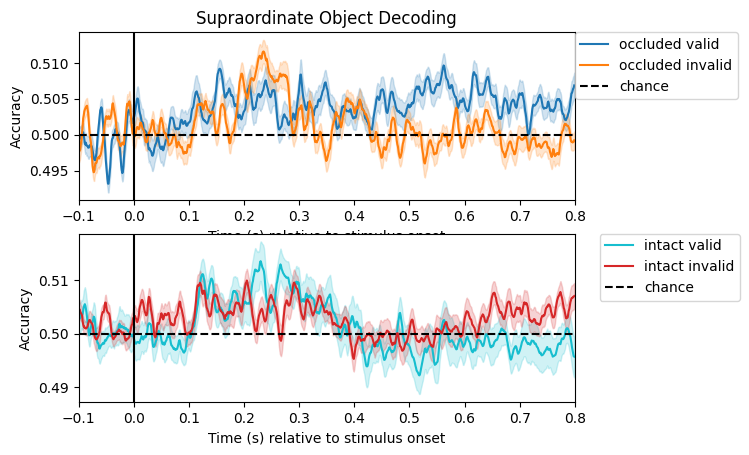

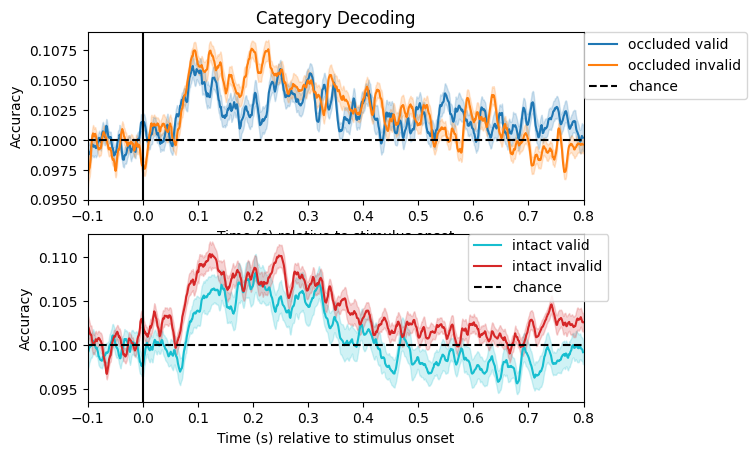

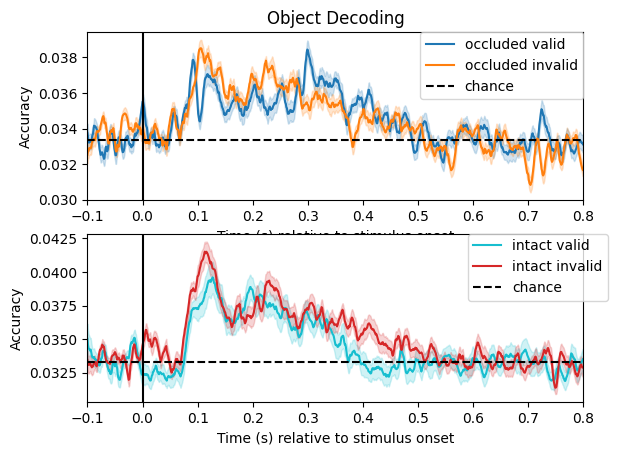

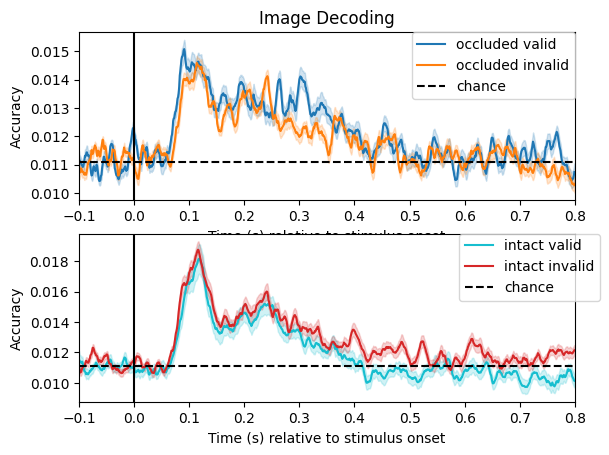

In [ ]:
def plot_decoding_subplot(ax1, ax2, means, se, title, chance_level):
    ax1.plot(time, means['_behind_valid_'], color='C0', label="occluded valid")
    ax1.plot(time, means['_behind_invalid_'], color='C1', label="occluded invalid")
    ax1.fill_between(time, means['_behind_valid_'] - se['_behind_valid_'], means['_behind_valid_'] + se['_behind_valid_'], color='C0', alpha=0.2)
    ax1.fill_between(time, means['_behind_invalid_'] - se['_behind_invalid_'], means['_behind_invalid_'] + se['_behind_invalid_'], color='C1', alpha=0.2)
    ax1.axhline(chance_level, color="k", linestyle="--", label="chance")
    ax1.set_xlim(-0.1, 0.8)
    ax1.set_xlabel("Time (s) relative to stimulus onset")
    ax1.set_ylabel("Accuracy")
    ax1.legend(bbox_to_anchor=(1, 1), loc=0, borderaxespad=0.)
    ax1.axvline(0.0, color="k", linestyle="-")
    ax1.set_title(title)

    ax2.plot(time, means['_front_valid_'], color='C9', label="intact valid")
    ax2.plot(time, means['_front_invalid_'], color='C3', label="intact invalid")
    ax2.fill_between(time, means['_front_valid_'] - se['_front_valid_'], means['_front_valid_'] + se['_front_valid_'], color='C9', alpha=0.2)
    ax2.fill_between(time, means['_front_invalid_'] - se['_front_invalid_'], means['_front_invalid_'] + se['_front_invalid_'], color='C3', alpha=0.2)
    ax2.axhline(chance_level, color="k", linestyle="--", label="chance")
    ax2.set_xlim(-0.1, 0.8)
    ax2.set_xlabel("Time (s) relative to stimulus onset")
    ax2.set_ylabel("Accuracy")
    ax2.legend(bbox_to_anchor=(1.05, 1), loc=0, borderaxespad=0.)
    ax2.axvline(0.0, color="k", linestyle="-")


# Supraordinate object decoding
fig1, (ax1_1, ax1_2) = plt.subplots(2)
plot_decoding_subplot(ax1_1, ax1_2, means_supra, stderror_supra, 'Supraordinate Object Decoding', 1/2)


# Category decoding
fig2, (ax2_1, ax2_2) = plt.subplots(2)
plot_decoding_subplot(ax2_1, ax2_2, means_cat, stderror_cat, 'Category Decoding', 1/10)


# Object decoding
fig3, (ax3_1, ax3_2) = plt.subplots(2)
plot_decoding_subplot(ax3_1, ax3_2, means_obj, stderror_obj, 'Object Decoding', 1/30)

# Image decoding
fig4, (ax4_1, ax4_2) = plt.subplots(2)
plot_decoding_subplot(ax4_1, ax4_2, means_img, stderror_img, 'Image Decoding', 1/90)


## 3.2.2. Bayes Factors main

Had to calculate the BFs using R, everything else in python

#### BF in R (ttestBF)
- Input: the smoothed decoding accuracies from each participant (f'{datapath}/derivatives/results_main/smoothed/sub{subjectnr}_results_{posval_codes[c]}', then it gets converted into 'derivatives/results_main/smoothed/alldata.csv'). </br>
    For BFs on the difference, first calculate valid - invalid looping per participant and timepoint for supra and obj</br>
    For BFs against chance level, calculate decoding - chancelevel  looping per participant and timepoint for supra (1/2) and obj (1/30) </br>
- Output: a csv with the BF values per timepoint, saved in /derivatives/results_main/stats/ (for the differences it has at least 'bf_differences' and something else) </br></br>
- Parameters: 
    - x = the differences (between conditions of against chance) per timepoint
    - y = </br>
        to use when doing paired-sample t-test
    - mu = 0 </br>
        null value of the mean (we're testing whether our x is greater than 0, because it's one-sample)
    - nullInterval = c(0.5,Inf) </br>
        prior range, to control for small effects</br>
        One-tailed prior-> half-Cauchy</br>
        Change the prior to full-Cauchy by setting nullInterval = c(-0.5, 0.5), complement = TRUE (and using x and y parametters to set a paired-sample t-test) -> for BF on the difference of Aligment
    - rscale = "medium" </br>
        default width (r = 0.707)
    

#### Snippet of the code in R-> to restructure dataframe

In [ ]:
'''Language: R'''

list_levels <- c('supraordinate', 'category', 'object', 'image')
all_data <- list()
for (c in names(posval_codes)) {
  for (j in 0:49) {
    subjectnr <- sprintf('%02d', j)
    infn <- file.path(datapath, "derivatives/results_main", paste0("sub-", subjectnr, "_results_", posval_codes[[c]], "_im.csv"))
    
    if (file.exists(infn)) {
      DF <- read.csv(infn)
      time <- DF$time
      
      for (level in colnames(DF)) {
        if (level %in% list_levels) {
          key <- paste0(subjectnr, c, level)
          all_data[[key]] <- DF[[level]]
        }
      }
    }
  }
}
DF <- as.data.frame(all_data)
DF$time <- time
output <- file.path(datapath, 'derivatives/results_main/alldata.csv')
write.csv(DF, output, row.names = FALSE)



n_timepoints <- length(time)

#column names
pattern <- "X(\\d\\d)_((\\w+)_(\\w+)_(\\w+))"

# data from all participants for each condition
condition_list <- list()
for (col in colnames(DF)) {
  match <- regmatches(col, regexec(pattern, col))
  if (length(match[[1]]) > 1) {
    condition <- match[[1]][2]
    
    if (!condition %in% names(condition_list)) {
      condition_list[[condition]] <- data.frame(row.names = time)
    }
    
    condition_list[[condition]][[col]] <- DF[[col]]
  }
}



# Re-structure the df
levels <- c('supraordinate', 'category', 'object', 'image')
positions <- c('front', 'behind')
validity<- c('valid', 'invalid')


valid_x <- list()
invalid_y <- list()
for (j in 0:31) {
  subjectnr <- sprintf('%02d', j)
  
  # Skip if subject doesn't exist in condition_list
  if (!subjectnr %in% names(condition_list)){
    print(subjectnr)
  }
  
  for (lev in levels) {
    for (val in validity) {
        # Create all key variants
        val_key <- paste0("X", subjectnr, "_behind_valid_", lev)
        inval_key <- paste0("X", subjectnr, "_behind_invalid_", lev)
        
        key <- paste0(lev)

        if (!key %in% names(valid_x)) {
          valid_x[[key]] <- data.frame(row.names = time)
        }
        
        if (!key %in% names(invalid_y)) {
          invalid_y[[key]] <- data.frame(row.names = time)
        }
        
        if (val_key %in% names(condition_list[[subjectnr]])) {
          valid_x[[key]][[subjectnr]]<- condition_list[[subjectnr]][[val_key]]
        }
        
        if (inval_key %in% names(condition_list[[subjectnr]])) {
          invalid_y[[key]][[subjectnr]] <- condition_list[[subjectnr]][[inval_key]]
      }
    }
  }
}

valid_x_df <- as.data.frame(valid_x)
invalid_y_df <- as.data.frame(invalid_y)


#### Snippet code in R -> to calculate BF of the difference in alignment (full-Cauchy)

In [ ]:
'''Language: R'''


# Hardcoding objects and supraordinate for full-cauchy
object_bf2 <- list()
### hardcoding objects
df_valid <- as.data.frame(valid_x[['object']])
df_invalid <- as.data.frame(invalid_y[['object']])
b_factors <- rep(NA_real_, n_timepoints)
for (t in 1:n_timepoints) {
  timepoint_value_valid <- na.omit(as.numeric(df_valid[t, ]))
  timepoint_value_invalid <- na.omit(as.numeric(df_invalid[t, ]))
  
  if (length(timepoint_value_valid) > 1) {
    tryCatch({
      
      results <- ttestBF(
        x = timepoint_value_valid,
        y = timepoint_value_invalid,
        nullInterval = c(-0.5, 0.5),
        paired = TRUE,
        rscale = "medium",
        complement = TRUE
      )
      print(results)
      b_factors[t] <- extractBF(results)[2, "bf"] # 2 is the complement
      
    }, error = function(e) {
      message("Error calculating BF for ", 'object', " at timepoint ", t, ": ", e$message)
    })
  }
}
object_bf2[[paste0("object_BF")]] <- b_factors
object_bf2[[paste0("object_timepoints")]] <- 1:n_timepoints 

### supra
supra_bf2 <- list()
df_valid <- as.data.frame(valid_x[['supraordinate']])
df_invalid <- as.data.frame(invalid_y[['supraordinate']])
b_factors <- rep(NA_real_, n_timepoints)
for (t in 1:n_timepoints) {
  timepoint_value_valid <- na.omit(as.numeric(df_valid[t, ]))
  timepoint_value_invalid <- na.omit(as.numeric(df_invalid[t, ]))

  if (length(timepoint_value_valid) > 1) {
    tryCatch({
      
      results <- ttestBF(
        x = timepoint_value_valid,
        y = timepoint_value_invalid,
        nullInterval = c(-0.5, 0.5),
        paired = TRUE,
        rscale = "medium",
        complement = TRUE
      )
      print(results)
      b_factors[t] <- extractBF(results)[2, "bf"]  ## 2 is the complement
      
    }, error = function(e) {
      message("Error calculating BF for ", 'supraordinate', " at timepoint ", t, ": ", e$message)
    })
  }
}
supra_bf2[[paste0("supraordinate_BF")]] <- b_factors
supra_bf2[[paste0("supraordinate_timepoints")]] <- 1:n_timepoints


output <- file.path(datapath, 'derivatives/results_main/stats/bf_differences_fullcauchy2.csv')
bayes_factors <- data.frame(
  object_BF = object_bf2[["object_BF"]],
  supraordinate_BF = supra_bf2[["supraordinate_BF"]],
  row.names = paste0("t", 1:length(object_bf[["object_BF"]]))
)
bayes_factors$time <- time
write.csv(bayes_factors, output, row.names = FALSE)

#### Snippet of code in R -> to calculate BF of conditions against chance 

In [ ]:
'''Language: R'''

# BFs against chance
chance_list <- list()
levels <- c('supraordinate', 'object')
validity <- c('valid', 'invalid')
position <- c('front', 'behind')

for (j in 0:40) {
  subjectnr <- sprintf('%02d', j)
  for (lev in levels) {
    for (val in validity) {
      in_key <- paste0("X", subjectnr, "_behind_", val, "_", lev)
      
      chance_key <- paste(val, lev, "chance", sep = "_")

      if ("supraordinate" %in% lev) {
        chance_level <- 0.5
      } else {
        chance_level <- 1/30
      }
      
      
      if (!chance_key %in% names(chance_list)) {
        chance_list[[chance_key]] <- data.frame(row.names = times)
      }
      if (in_key %in% colnames(condition_list[[subjectnr]])) {
        chance_result <- condition_list[[subjectnr]][[in_key]] - chance_level
        
        chance_list[[chance_key]][[subjectnr]] <- chance_result
      }
    }
  }
}

Chance <- as.data.frame(chance_list)
output <- file.path(datapath, 'derivatives/results_main/stats/against_chance.csv')
write.csv(Chance, output, row.names = FALSE)



dict_bf<- list()
for (condition_code in names(chance_list)) {
  df_condition <- chance_list[[condition_code]]
  
  b_factors <- numeric(n_timepoints)
  
  for (t in 1:n_timepoints) {
    time_point_data <- as.numeric(df_condition[t, ])
    time_point_data <- time_point_data[!is.na(time_point_data)]
    
    if (length(time_point_data) > 1) {
      results <- ttestBF(x = time_point_data, mu = 0, nullInterval = c(0.5,Inf), rscale = "medium")
      
      print(results)  # Debug: print the `results` object
      
      b_factors[t] <- results
      
    }
  }
  dict_bf[[paste0(condition_code, "_chance_BF")]] <- b_factors
}


output <- file.path(datapath, 'derivatives/results_main/stats/bf_chance.csv')
bayes_factors <- as.data.frame(dict_bf)
bayes_factors$time <- time
write.csv(bayes_factors, output, row.names = FALSE)


#### Print consecutive BFs above 6


In [ ]:
# PRINT CONSECUTIVE BFS ABOVE 6 FOR EACH CONDITION AGAINST CHANCE LEVEL

fn_bf_chance = f'{datapath}/derivatives/results_main/stats/bf_chance.csv'
bf_chance = pd.read_csv(fn_bf_chance)
time_bf = bf_chance['time']
times_numeric = np.linspace(-100, 800, len(time_bf))


for target_label, bf_values in bf_chance.items():
        print(f"Sequences of high Bayes Factors for {target_label.replace('_', ' ')}:")
        start_index = None

        # Iterate through the indices of the Bayes Factors
        for i in range(len(bf_values) - 2):  # Ensure we don't go out of range
        
            if bf_values[i] > 2:
                if start_index is None:
                    start_index = i  # Start of a new sequence
            else:
                if start_index is not None:
                    # End of the sequence
                    if i - start_index >= 9:  # We include at least 10 points, so the difference should be >= 2
                        print(f"High BF sequence from {int(times_numeric[start_index])} ms to {int(times_numeric[i])} ms.")
                    start_index = None  # Reset start index

        # Check if there's an ongoing sequence at the end of the list
        if start_index is not None and len(bf_values) - start_index >=3:
            print(f"High BF sequence from {int(times_numeric[start_index])} ms to {int(times_numeric[len(bf_values) - 1])} ms.")

Sequences of high Bayes Factors for valid supraordinate chance BF:
High BF sequence from 149 ms to 163 ms.
High BF sequence from 528 ms to 539 ms.
High BF sequence from 557 ms to 577 ms.
High BF sequence from 614 ms to 624 ms.
High BF sequence from 636 ms to 649 ms.
Sequences of high Bayes Factors for invalid supraordinate chance BF:
High BF sequence from 219 ms to 244 ms.
High BF sequence from 254 ms to 268 ms.
Sequences of high Bayes Factors for valid object chance BF:
High BF sequence from 83 ms to 101 ms.
High BF sequence from 108 ms to 148 ms.
High BF sequence from 159 ms to 174 ms.
High BF sequence from 197 ms to 224 ms.
High BF sequence from 244 ms to 261 ms.
High BF sequence from 277 ms to 364 ms.
High BF sequence from 378 ms to 400 ms.
High BF sequence from 402 ms to 418 ms.
Sequences of high Bayes Factors for invalid object chance BF:
High BF sequence from 85 ms to 290 ms.
High BF sequence from 307 ms to 339 ms.
High BF sequence from 347 ms to 358 ms.
Sequences of high Bayes 

In [ ]:
# PRINT CONSECUTIVE BFS ABOVE 6 FOR EACH CONDITION (DIFFERENCES BETWEEN CONDITIONS)

fn_bf_diff = f'{datapath}/derivatives/results_main/stats/bf_differences_fullcauchy2.csv'
bf_diff = pd.read_csv(fn_bf_diff)
time_bf = bf_diff['time']
times_numeric = np.linspace(-100, 800, len(time_bf))


for target_label, bf_values in bf_diff.items():
        print(f"Sequences of high Bayes Factors for {target_label.replace('_', ' ')}:")
        start_index = None

        # Iterate through the indices of the Bayes Factors
        for i in range(len(bf_values) - 2):  # Ensure we don't go out of range
        
            if bf_values[i] >= 3:
                if start_index is None:
                    start_index = i  # Start of a new sequence
            else:
                if start_index is not None:
                    # End of the sequence
                    if i - start_index >= 9:  # We include at least 10 points, so the difference should be >= 2
                        print(f"High BF sequence from {int(times_numeric[start_index])} ms to {int(times_numeric[i])} ms.")
                    start_index = None  # Reset start index

        # Check if there's an ongoing sequence at the end of the list
        if start_index is not None and len(bf_values) - start_index >=3:
            print(f"High BF sequence from {int(times_numeric[start_index])} ms to {int(times_numeric[len(bf_values) - 1])} ms.")

Sequences of high Bayes Factors for object BF:
Sequences of high Bayes Factors for supraordinate BF:
Sequences of high Bayes Factors for time:


### Plot main decoding accuracies with BFs

Params plot_decoding_subplot:
+ means = means_supra or means_obj, from the averaging and smoothing cell
+ se = stderror_supra or stderror_obj, from the averaging and smoothing cell
+ bf_chance = f'{datapath}/derivatives/results_main/stats/bf_chance.csv', loaded when printing BF>6
+ bf_diff = any csv with 'bf_differences' in it, depending on the plot
+ condition_code = 'supraordinate' or 'object', just to get certain df columns
+ desc = 'Category' or 'Object', description for the legends and titles
+ chance_level = 1/2 for category (supra) or 1/30 for objects


In [ ]:
means_supra = pd.DataFrame(means_supra, index=time)
means_cat = pd.DataFrame(means_cat, index=time)
means_obj = pd.DataFrame(means_obj, index=time)
means_img = pd.DataFrame(means_img, index=time)

fn_bf_diff = f'{datapath}/derivatives/results_main/stats/bf_differences_fullcauchy2.csv' 
bf_diff = pd.read_csv(fn_bf_diff)

In [ ]:
def plot_decoding_subplot(ax1, ax2, ax3, ax4, means, se, bf_chance, bf_diff, condition_code, desc, chance_level):
    """
    Plot decoding accuracy and Bayes Factors for a specific condition.
    Parameters
    ----------
    ax1, ax2, ax3, ax4 : matplotlib axes
        Axes to plot the decoding accuracy and Bayes Factors.
    means : dict
        Dictionary containing the means of the decoding accuracy for each condition.
    se : dict
        Dictionary containing the standard errors of the decoding accuracy for each condition.
    bf_chance : dict
        Dictionary containing the Bayes Factors against chance level for each condition.
    bf_diff : dict
        Dictionary containing the Bayes Factors for the difference between conditions.
    condition_code : str
        Condition code to identify the specific condition being plotted.
    desc : str
        Description of the condition being plotted.
    chance_level : float
        Chance level for the decoding accuracy.


    """

    behind_colors = ['C0', 'C1']  # Colours for behind valid and invalid

    #decoding accuracy for the "behind" condition
    for i, validity in enumerate(['valid', 'invalid']):
        ax1.plot(time, means[f'_behind_{validity}_'], color=behind_colors[i], label=f"{validity}")
        ax1.fill_between(time, means[f'_behind_{validity}_'] - se[f'_behind_{validity}_'], means[f'_behind_{validity}_'] + se[f'_behind_{validity}_'], color=behind_colors[i], alpha=0.2)
    ax1.axhline(chance_level, color="k", linestyle="--", label="chance")
    ax1.set_xlim(-0.1, 0.8)
    ax1.axvline(0.0, color="k", linestyle="-")
    ax1.set_xticks(np.arange(-0.1, 0.9, step=0.1))
    ax1.tick_params(labelsize=20)
    ax1.set_title(f'{desc} Decoding \n', fontsize=30)
    lines = ax1.get_lines()
    ax1.legend([lines[0], lines[1], lines[2]],['Aligned', 'Misaligned', 'Chance'], bbox_to_anchor=(1, 1), loc=0, borderaxespad=0., fontsize=20)
    
    #ax1.set_xlabel("Time (s) \n", fontsize=20)
    ax1.set_ylabel("Accuracy", fontsize=30)

    # Plot Bayes Factors against chance level valid
    chance_key_valid = f'valid_{condition_code}_chance_BF'
    if chance_key_valid in bf_chance:
        y = bf_chance[chance_key_valid].values
        ax2.plot(time, y, label='Bayes Factor')
        exponential_minmax = 6
        val_col_map = np.logspace(-exponential_minmax, exponential_minmax, num=500)
        
        markerline, stemlines, baseline = ax2.stem(time, y, bottom=1, linefmt='k', markerfmt=None, basefmt=None)
        markerline.set_markerfacecolor('w')
        markerline.set_markeredgecolor('w')
        baseline.set_color('k')
        stemlines.set_linewidth(0.1)
        
        cols_idx = [np.argmin(np.abs(val_col_map - abs(val))) for val in y]  
        for i in range(len(cols_idx)):
            ax2.plot(time[i], y[i], color='C0', marker='.', markersize=10, lw=0, markeredgecolor=None)
        ax2.set_yscale('log')
        ax2.set_ylim([10**-exponential_minmax, 10**exponential_minmax])
        ax2.set_yticks([1.e-7, 1, 1.e+7])   #zoom in/out y-axis
        ax2.set_xlim(-0.1, 0.8)
        ax2.axvline(0.0, color="k", linestyle="-")
        ax2.get_xaxis().get_major_formatter().labelOnlyBase = True
        ax2.set_xticks(np.arange(-0.1, 0.9, step=0.1))
        ax2.tick_params(labelsize=20)

        ax2.spines['right'].set_visible(False)
        ax2.spines['top'].set_visible(False)
        ax2.set_ylabel('Bayes Factor (log) \n Aligned-chance', fontsize=30)


    # BFs against chance level invalid
    chance_key_invalid = f'invalid_{condition_code}_chance_BF'
    if chance_key_invalid in bf_chance:
        y = bf_chance[chance_key_invalid].values
        ax3.plot(time, y, label='Bayes Factor')
        exponential_minmax = 6
        val_col_map = np.logspace(-exponential_minmax, exponential_minmax, num=500)
        
        markerline, stemlines, baseline = ax3.stem(time, y, bottom=1, linefmt='k', markerfmt=None, basefmt=None)
        markerline.set_markerfacecolor('w')
        markerline.set_markeredgecolor('w')
        baseline.set_color('k')
        stemlines.set_linewidth(0.1)
        
        cols_idx = [np.argmin(np.abs(val_col_map - abs(val))) for val in y]  
        for i in range(len(cols_idx)):
            ax3.plot(time[i], y[i], color='C1', marker='.', markersize=10, lw=0, markeredgecolor=None)
        ax3.set_yscale('log')
        ax3.set_ylim([10**-exponential_minmax, 10**exponential_minmax])
        ax3.set_yticks([1.e-7, 1, 1.e+7])  #zoom in/out y-axis
        ax3.set_xlim(-0.1, 0.8)
        ax3.axvline(0.0, color="k", linestyle="-")
        ax3.get_xaxis().get_major_formatter().labelOnlyBase = True
        ax3.set_xticks(np.arange(-0.1, 0.9, step=0.1))
        ax3.tick_params(labelsize=20)

        ax3.spines['right'].set_visible(False)
        ax3.spines['top'].set_visible(False)
        ax3.set_ylabel('Bayes Factor (log) \nMisaligned-chance', fontsize=30)


    # BFs for the difference between conditions
    diff_key_behind = f'valid_{condition_code}_diff_BF'
    if diff_key_behind in bf_diff:
        y = bf_diff[diff_key_behind].values
        ax4.plot(time, y, label='Bayes Factor')
        exponential_minmax = 7 #zoom in/out y-axis
        val_col_map = np.logspace(-exponential_minmax, exponential_minmax, num=500)
        
        markerline, stemlines, baseline = ax4.stem(time, y, bottom=1, linefmt='k', markerfmt=None, basefmt=None)
        markerline.set_markerfacecolor('w')
        markerline.set_markeredgecolor('w')
        baseline.set_color('k')
        stemlines.set_linewidth(0.1)
        
        cols_idx = [np.argmin(np.abs(val_col_map - abs(val))) for val in y]
        for i in range(len(cols_idx)):
            ax4.plot(time[i], y[i], color='C2', marker='.', markersize=10, lw=0, markeredgecolor=None)

            
        ax4.set_yscale('log')
        ax4.set_ylim([10**-exponential_minmax, 10**exponential_minmax])
        ax4.set_yticks([1.e-7, 1, 1.e+7])   #zoom in/out y-axis
        ax4.set_xlim(-0.1, 0.8)
        ax4.axvline(0.0, color="k", linestyle="-")
        ax4.get_xaxis().get_major_formatter().labelOnlyBase = True
        ax4.set_xticks(np.arange(-0.1, 0.9, step=0.1))
        ax4.tick_params(labelsize=20)
        
        ax4.spines['right'].set_visible(False)
        ax4.spines['top'].set_visible(False)
        
        #ax4.set_title(f'\n\n Difference Alignment', fontsize=20)
        ax4.set_xlabel('Time (s) \n', fontsize=20)
        ax4.set_ylabel('Bayes Factor (log) \n Valid-Invalid', fontsize=27)


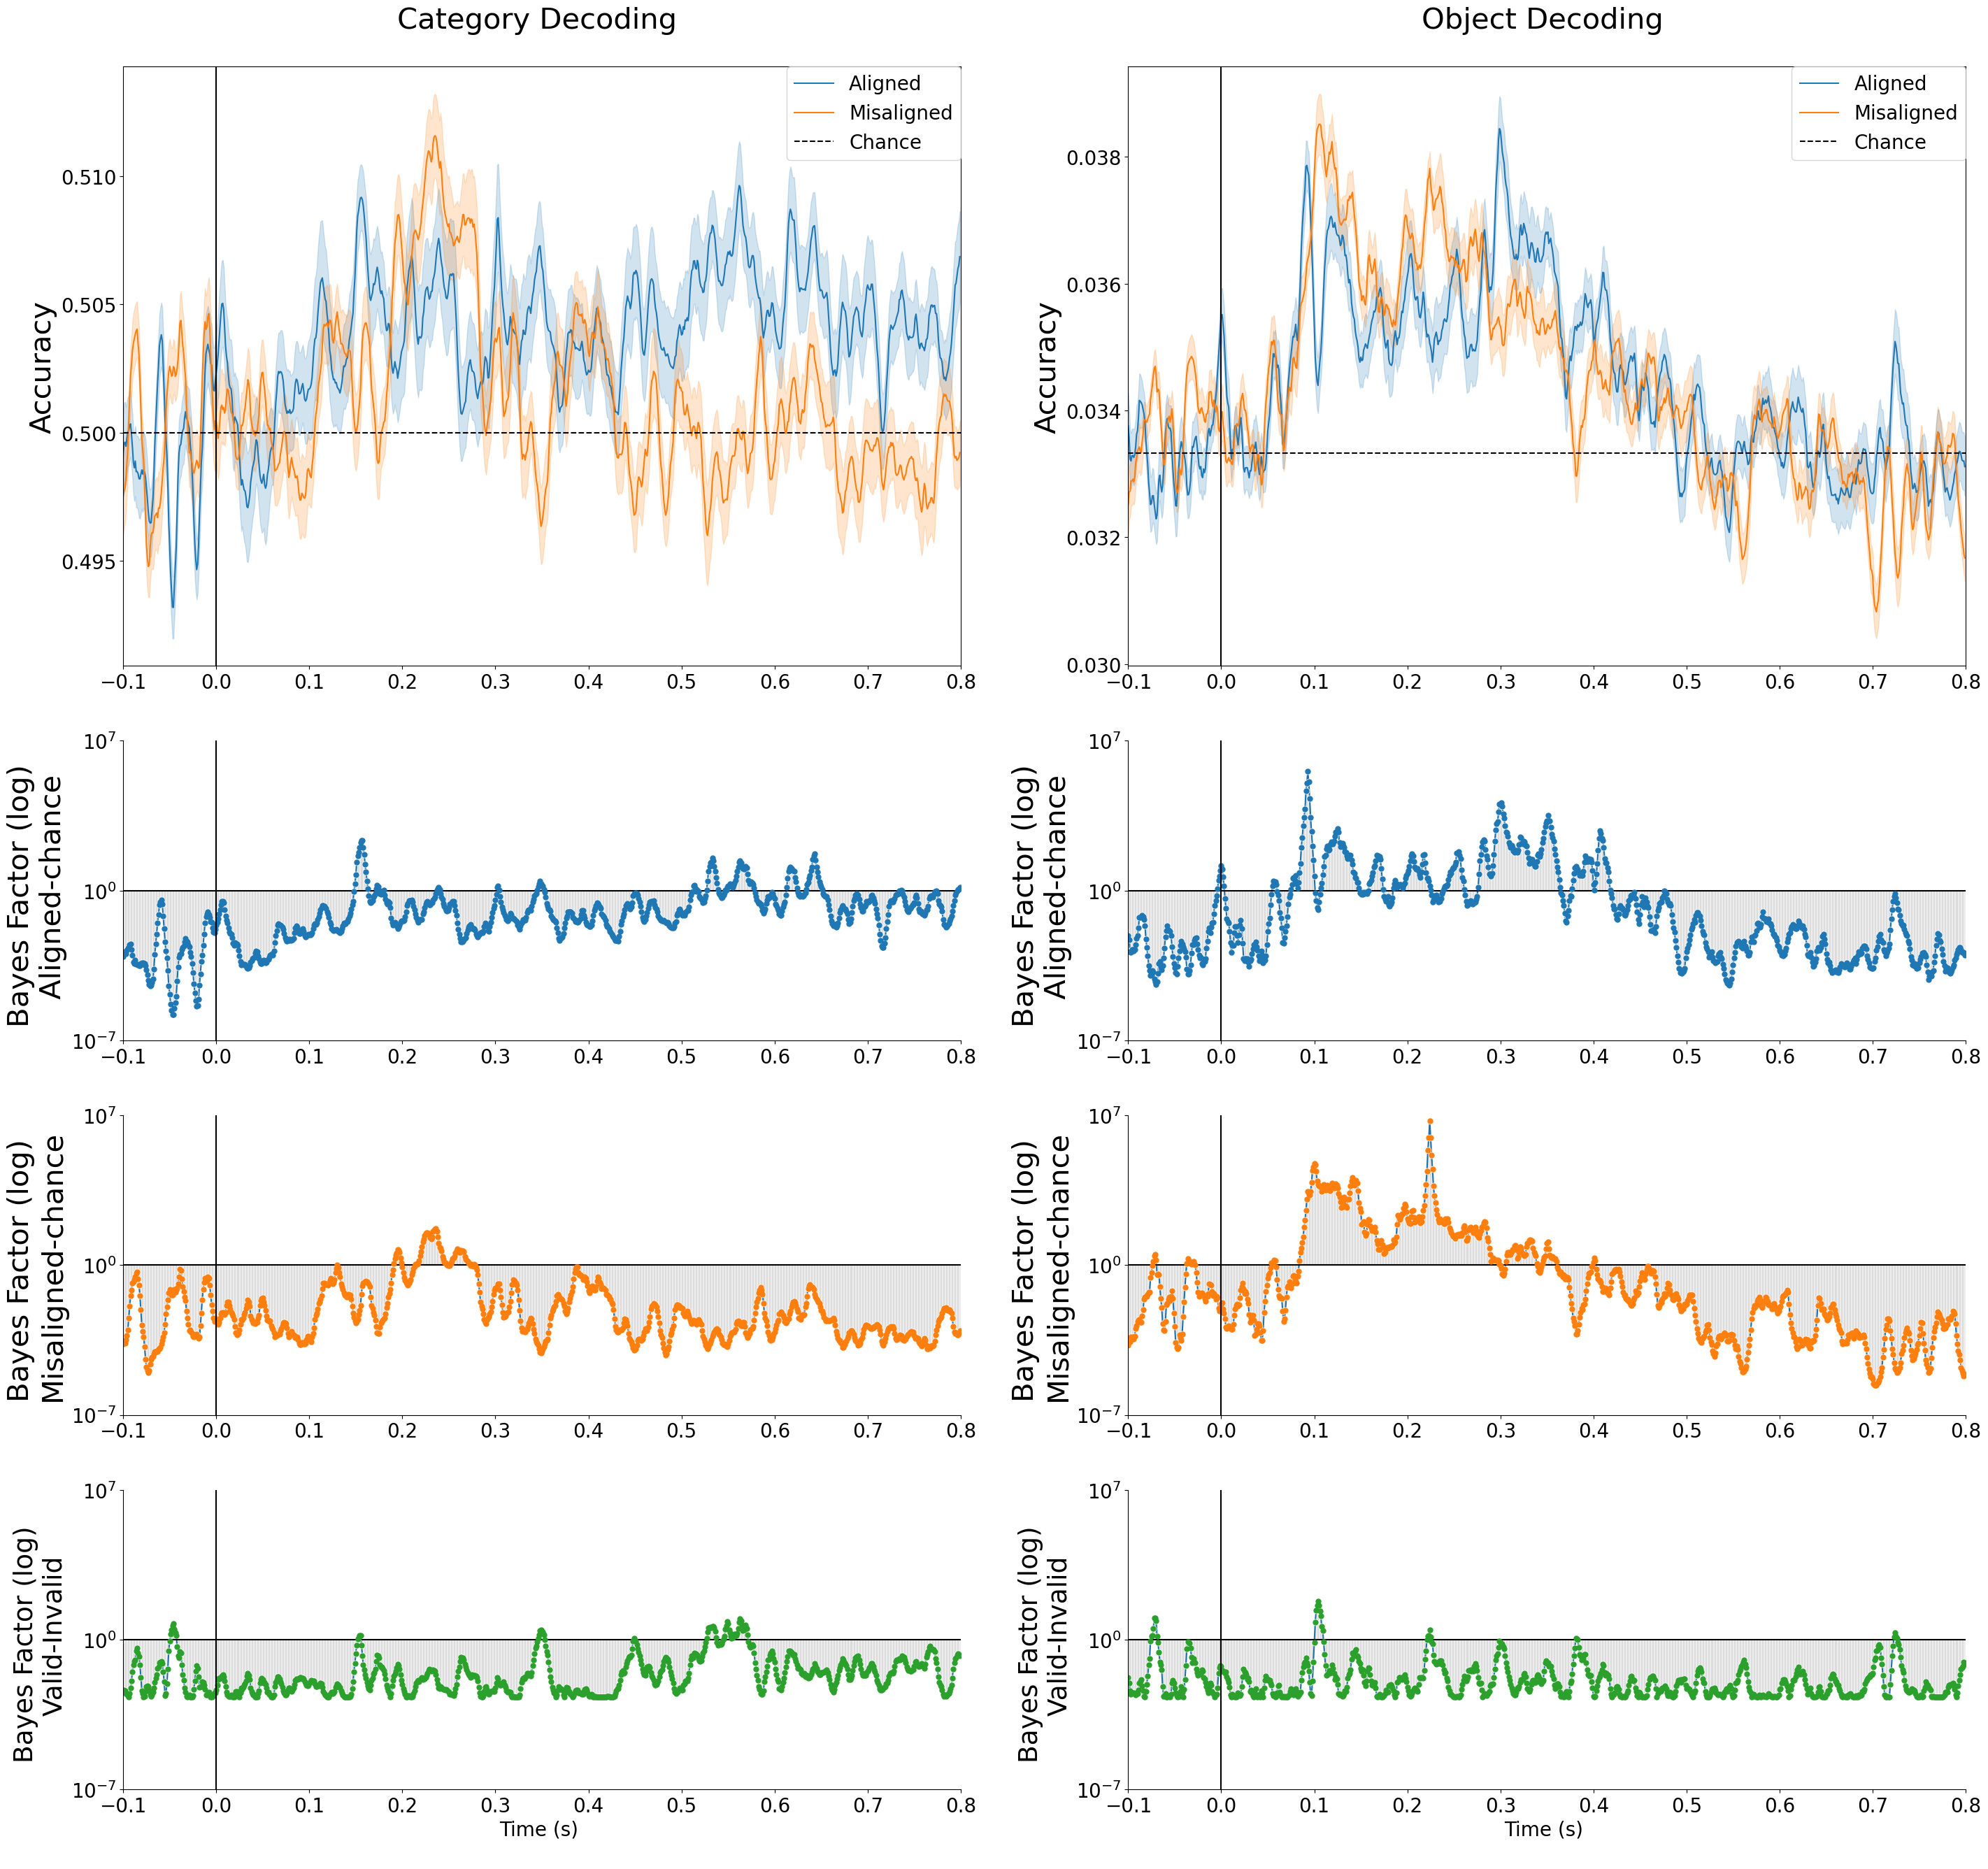

In [ ]:

fig, axs = plt.subplots(4, 2, figsize=(34, 32), gridspec_kw={'height_ratios': [2, 1, 1, 1]})
ax1_1 = fig.add_subplot(axs[0, 0])
ax1_2 = fig.add_subplot(axs[1, 0])
ax1_3 = fig.add_subplot(axs[2, 0])
ax1_4 = fig.add_subplot(axs[3, 0])
ax2_1 = fig.add_subplot(axs[0, 1])
ax2_2 = fig.add_subplot(axs[1, 1])
ax2_3 = fig.add_subplot(axs[2, 1])
ax2_4 = fig.add_subplot(axs[3, 1])
#plt.tight_layout()

plot_decoding_subplot(ax1_1, ax1_2, ax1_3, ax1_4, means_supra, stderror_supra, bf_chance, bf_diff, 'supraordinate', 'Category', 1/2)
plot_decoding_subplot(ax2_1, ax2_2, ax2_3, ax2_4, means_obj, stderror_obj, bf_chance, bf_diff, 'object', 'Object', 1/30)
